In [1]:
import torchvision, torch
from torchvision import datasets, models, transforms
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import matplotlib.pyplot as plt

In [2]:
class CardDataSet(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None,target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform=target_transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [39]:
root = os.getcwd()
BATCH_SIZE = 50
transform = transforms.Compose(
        [transforms.Resize([256,256]),
         ])
dataset = CardDataSet(root+"\\train.csv",root+"\\train\\train\\",transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

Feature batch shape: torch.Size([50, 3, 256, 256])
Labels batch shape: torch.Size([50])


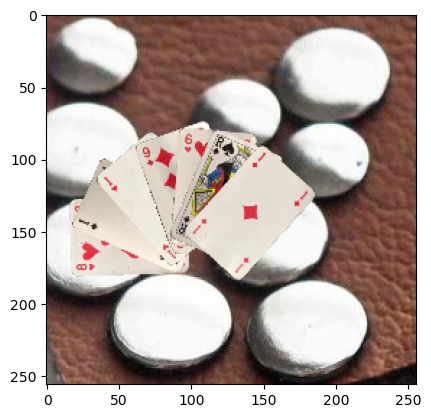

Label: 37


In [44]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#print(train_features)
img = train_features[0].squeeze().permute(1,2,0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
root = os.getcwd()
BATCH_SIZE = 50
transform = transforms.Compose(
        [transforms.Resize([256,256])])
dataset = CardDataSet(root+"\\train.csv",root+"\\train\\train\\",transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
 

TypeError: DataLoader.__init__() got an unexpected keyword argument 'train'

In [37]:
labels = pd.read_csv(root+"\\train.csv")
labels.head()

,Filename,Total
0,000093681.jpg,37
1,000169578.jpg,50
2,000827954.jpg,35
3,001075659.jpg,45
4,001558425.jpg,53


# Model

In [124]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ConvTranspose2d
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LazyLinear
from torchvision.transforms import CenterCrop
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import ModuleList
from torch import flatten

In [125]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [126]:
class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                 for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

In [127]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [128]:
class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
            decChannels=(64, 32, 16),
            nbClasses=1, retainDim=True,
            outSize=(256,  256)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
        encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [129]:
class Cnn(Module):
    def __init__(self, numChannels):
        # call the parent constructor
        super(Cnn, self).__init__()
        # initialize first set of CONV => RELU => POOL layers
        self.unet = UNet()
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=5,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=5, out_channels=10,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = LazyLinear( out_features=50)
        self.relu3 = ReLU()
        # initialize our output
        self.fc2 = Linear(in_features=50, out_features=1)
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.unet(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        output = self.fc2(x)
        
        # return the output predictions
        return output

# Training

In [5]:
import matplotlib

# import the necessary packages

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [49]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 100
EPOCHS = 3
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

root = os.getcwd()

transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Resize([256,256])])

trainData = CardDataSet(root+"\\train.csv",root+"\\train\\train\\",transform)

print("[INFO] generating the train/validation split...")

numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)

(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(trainData, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)

print("[INFO] generating the train/validation split...")

# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE
print(trainSteps)
print(valSteps)

[INFO] generating the train/validation split...
[INFO] generating the train/validation split...
37
12


In [122]:
model = Cnn(numChannels=3)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
loss_fn = nn.MSELoss()


# initialize a dictionary to store training history
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()
# loop over our epochs
for e in range(0, EPOCHS):
    # set the model in training mode
    print(e)
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    cnt = 0
    # loop over the training set
    for (x, y) in train_loader:
        print(cnt)
        cnt +=1
        # perform a forward pass and calculate the training loss
        pred = model(x)
        RMSE_loss = torch.sqrt(loss_fn(pred.squeeze(), y.float()))
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        RMSE_loss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += RMSE_loss
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in val_loader:
            
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += torch.sqrt(loss_fn(pred.squeeze(), y.float()))
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())

        H["val_loss"].append(avgValLoss.cpu().detach().numpy())

        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
        print("Train loss: {:.6f}\n".format(
            avgTrainLoss))
        print("Val loss: {:.6f}\n".format(
            avgValLoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))


D:\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
D:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[INFO] training the network...
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
[INFO] EPOCH: 1/3
Train loss: 16.312790

Val loss: 12.372687

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
[INFO] EPOCH: 2/3
Train loss: 11.465376

Val loss: 11.651021

2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
[INFO] EPOCH: 3/3
Train loss: 10.812991

Val loss: 10.620165

[INFO] total time taken to train the model: 787.36s


# Predict

In [73]:
transform = transforms.Compose(
        [
         transforms.ToTensor(),
         transforms.Resize([256,256])])
test_data = datasets.ImageFolder(root+'\\test', transform=transform)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:\Users\HP\Documents\Untitled Folder\test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
           )


In [80]:
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# EXAMPLE USAGE:
# instantiate the dataset and dataloader
root = os.getcwd()
test_data = ImageFolderWithPaths(root +"\\test",transform) # our custom dataset




In [123]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
res = []
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        i = 0
        for (x, y,p) in test_loader:
            
            # make the predictions and calculate the validation loss
            pred = model(x)
            i += 1
            print(i, p[0][48:], pred[0][0].numpy())
            res.append([p[0][48:],pred[0][0].numpy()])
print(res)        

1 003212838.jpg 52.278355
2 004233379.jpg 54.49407
3 004453340.jpg 46.580936
4 004775467.jpg 43.32026
5 006458192.jpg 46.68236
6 010705350.jpg 49.46084
7 011020442.jpg 52.13142
8 013318771.jpg 41.566853
9 015926568.jpg 42.58046
10 017438292.jpg 48.788822
11 018418495.jpg 52.275738
12 018669280.jpg 45.843334
13 019378321.jpg 45.21971
14 020612712.jpg 46.894985
15 022225819.jpg 43.778706
16 022886613.jpg 53.69134
17 023620293.jpg 39.460865
18 023930297.jpg 49.818348
19 025962357.jpg 46.54875
20 026054603.jpg 44.53462
21 026255945.jpg 44.327137
22 026291895.jpg 38.922077
23 026976499.jpg 46.637096
24 030609132.jpg 47.338764
25 033281934.jpg 48.507698
26 033420953.jpg 51.722485
27 033729593.jpg 44.897488
28 035594217.jpg 46.582737
29 037558035.jpg 47.117954
30 038298958.jpg 45.478214
31 039918443.jpg 47.209362
32 043603436.jpg 44.400204
33 046891745.jpg 49.056805
34 048697279.jpg 48.67055
35 049895181.jpg 45.871735
36 051605206.jpg 41.86805
37 051843630.jpg 52.061855
38 052402264.jpg 40.37

304 311997483.jpg 51.767204
305 312745558.jpg 42.343685
306 314224233.jpg 46.768345
307 314874447.jpg 49.13216
308 316061686.jpg 47.03649
309 319043831.jpg 52.17557
310 319336257.jpg 44.017635
311 320013052.jpg 49.2896
312 320144966.jpg 52.325256
313 321978126.jpg 47.0125
314 322724766.jpg 45.01003
315 322850658.jpg 48.78237
316 322878380.jpg 49.057293
317 322943327.jpg 47.93188
318 325087773.jpg 53.17351
319 325518278.jpg 45.611214
320 326261956.jpg 48.982105
321 327698613.jpg 49.716328
322 327847525.jpg 50.484623
323 328021680.jpg 47.80685
324 328903343.jpg 48.610985
325 329155624.jpg 49.532368
326 330291610.jpg 46.595043
327 331198845.jpg 43.24535
328 333908187.jpg 47.1518
329 334877498.jpg 44.280857
330 337927959.jpg 45.705845
331 340037706.jpg 50.52828
332 340732660.jpg 44.576424
333 340754599.jpg 42.084225
334 341201092.jpg 51.299877
335 341469832.jpg 45.9537
336 342201310.jpg 53.341568
337 342763565.jpg 47.04898
338 343124471.jpg 46.32294
339 344280104.jpg 49.750256
340 34508819

606 611006761.jpg 46.686016
607 611293430.jpg 55.473476
608 611567302.jpg 47.825775
609 611581457.jpg 47.722477
610 612116720.jpg 48.171333
611 613043902.jpg 46.761776
612 614037025.jpg 52.16923
613 616894163.jpg 45.71296
614 616948582.jpg 50.535717
615 617055306.jpg 45.14192
616 617633754.jpg 52.339043
617 617984720.jpg 48.43064
618 618125239.jpg 44.10796
619 618481753.jpg 49.368587
620 619285380.jpg 49.808887
621 619426263.jpg 40.142857
622 620313270.jpg 47.449238
623 621148068.jpg 47.29529
624 622409135.jpg 48.891403
625 623267083.jpg 42.583763
626 623749392.jpg 45.613903
627 624655088.jpg 50.807537
628 624802803.jpg 44.118977
629 625998902.jpg 50.378498
630 626282024.jpg 45.493504
631 626582504.jpg 45.788006
632 627074237.jpg 48.155457
633 628921318.jpg 45.73573
634 629049632.jpg 47.912106
635 629562700.jpg 45.399918
636 629890383.jpg 51.527027
637 630058909.jpg 48.195686
638 631540356.jpg 48.8342
639 632228419.jpg 52.092167
640 633933267.jpg 47.6024
641 634540725.jpg 50.074375
642

904 894773202.jpg 45.197266
905 899647113.jpg 47.838108
906 901532238.jpg 51.252136
907 901890881.jpg 52.09185
908 905503740.jpg 40.863914
909 906406205.jpg 42.97537
910 907936507.jpg 46.682682
911 910127043.jpg 52.690586
912 911142379.jpg 49.381664
913 914825890.jpg 52.527355
914 914934280.jpg 44.08276
915 915535520.jpg 43.920803
916 916320365.jpg 50.442463
917 916371246.jpg 50.810642
918 916685065.jpg 46.784363
919 917186534.jpg 49.47965
920 919898082.jpg 49.522797
921 922560713.jpg 48.711338
922 923198501.jpg 46.400333
923 924501489.jpg 46.217236
924 925007400.jpg 42.88151
925 925236453.jpg 46.63081
926 925346020.jpg 44.132816
927 926151626.jpg 45.322617
928 926462990.jpg 44.121624
929 927249599.jpg 45.251667
930 928785454.jpg 51.11722
931 930873139.jpg 45.701824
932 931162901.jpg 43.42452
933 932709862.jpg 48.710224
934 932937187.jpg 44.526142
935 933218611.jpg 40.113472
936 933393441.jpg 48.306545
937 938953055.jpg 43.570587
938 939020268.jpg 39.150436
939 939200347.jpg 55.2049
94

[['003212838.jpg', array(55.27612, dtype=float32)], ['004233379.jpg', array(58.456425, dtype=float32)], ['004453340.jpg', array(43.876694, dtype=float32)], ['004775467.jpg', array(43.3466, dtype=float32)], ['006458192.jpg', array(46.622856, dtype=float32)], ['010705350.jpg', array(46.21706, dtype=float32)], ['011020442.jpg', array(54.493576, dtype=float32)], ['013318771.jpg', array(42.74044, dtype=float32)], ['015926568.jpg', array(43.28036, dtype=float32)], ['017438292.jpg', array(48.229355, dtype=float32)], ['018418495.jpg', array(53.545116, dtype=float32)], ['018669280.jpg', array(47.198517, dtype=float32)], ['019378321.jpg', array(45.16353, dtype=float32)], ['020612712.jpg', array(48.797386, dtype=float32)], ['022225819.jpg', array(45.187496, dtype=float32)], ['022886613.jpg', array(52.860622, dtype=float32)], ['023620293.jpg', array(40.126347, dtype=float32)], ['023930297.jpg', array(47.55997, dtype=float32)], ['025962357.jpg', array(47.322945, dtype=float32)], ['026054603.jpg', a

In [112]:
result = []
for i in res :
    result += [i[0],i[1].asarray()]
print(result)

AttributeError: 'numpy.ndarray' object has no attribute 'asarray'

In [120]:
df = pd.DataFrame(res)
df.head()
df.to_csv("result.csv",index=False)

In [117]:
df2 = pd.read_csv("result.csv")
df2.head()

,Filename,Total
0,003212838.jpg,55.276120
1,004233379.jpg,58.456425
2,004453340.jpg,43.876694
3,004775467.jpg,43.346600
4,006458192.jpg,46.622856
